In [1]:
import os
os.chdir('modules')
from train import train, score
from get_data import get_data
from model import LangID, LogisticRegression, ComplementNB, BernoulliNB
from get_gpt_reviews import get_gpt_reviews
import matplotlib.pyplot as plt
from random import shuffle
import numpy as np
Xt, Yt = get_data("dev", cleanText=True)

import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.simplefilter("ignore", category=ConvergenceWarning)

import sys
# the mock-0.3.1 dir contains testcase.py, testutils.py & mock.py
from get_data import get_data
import pandas as pd
import seaborn as sns
from tqdm.notebook import trange, tqdm
from model import OnehotTransformer,LogisticRegressionPytorch
import torch

Device used = cuda



Doing size 10
Fitted vocab size: 903
Deleting 2 constituting 0.0019801980198019802 percent
Fitted vocab size: 903
Deleting 100 constituting 0.09900990099009901 percent
Fitted vocab size: 901
Deleting 200 constituting 0.19801980198019803 percent
Fitted vocab size: 894
Deleting 300 constituting 0.297029702970297 percent
Fitted vocab size: 878
Deleting 400 constituting 0.39603960396039606 percent
Fitted vocab size: 851
Deleting 500 constituting 0.49504950495049505 percent
Fitted vocab size: 818
Deleting 600 constituting 0.594059405940594 percent
Fitted vocab size: 754
Deleting 700 constituting 0.693069306930693 percent
Fitted vocab size: 672
Deleting 800 constituting 0.7920792079207921 percent
Fitted vocab size: 568
Deleting 900 constituting 0.8910891089108911 percent
Fitted vocab size: 426
Deleting 1000 constituting 0.9900990099009901 percent
Fitted vocab size: 180


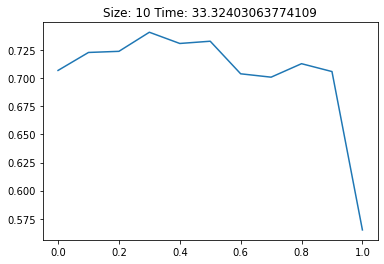


Doing size 50
Fitted vocab size: 3449
Deleting 2 constituting 0.00039603960396039607 percent
Fitted vocab size: 3449
Deleting 500 constituting 0.09900990099009901 percent
Fitted vocab size: 3445
Deleting 1000 constituting 0.19801980198019803 percent
Fitted vocab size: 3429
Deleting 1500 constituting 0.297029702970297 percent
Fitted vocab size: 3398
Deleting 2000 constituting 0.39603960396039606 percent
Fitted vocab size: 3296
Deleting 2500 constituting 0.49504950495049505 percent
Fitted vocab size: 3143
Deleting 3000 constituting 0.594059405940594 percent
Fitted vocab size: 2923
Deleting 3500 constituting 0.693069306930693 percent
Fitted vocab size: 2631
Deleting 4000 constituting 0.7920792079207921 percent
Fitted vocab size: 2338
Deleting 4500 constituting 0.8910891089108911 percent
Fitted vocab size: 1890
Deleting 5000 constituting 0.9900990099009901 percent
Fitted vocab size: 940


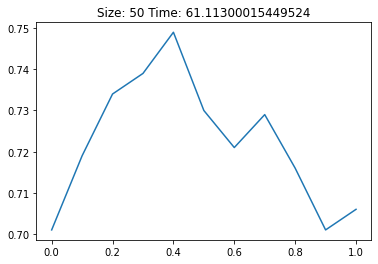


Doing size 100
Fitted vocab size: 2830
Deleting 2 constituting 0.00019801980198019803 percent
Fitted vocab size: 2830
Deleting 1000 constituting 0.09900990099009901 percent
Fitted vocab size: 4000
Deleting 2000 constituting 0.19801980198019803 percent
Fitted vocab size: 4000
Deleting 3000 constituting 0.297029702970297 percent
Fitted vocab size: 4000
Deleting 4000 constituting 0.39603960396039606 percent
Fitted vocab size: 4000
Deleting 5000 constituting 0.49504950495049505 percent
Fitted vocab size: 3881
Deleting 6000 constituting 0.594059405940594 percent
Fitted vocab size: 3630
Deleting 7000 constituting 0.693069306930693 percent
Fitted vocab size: 3252
Deleting 8000 constituting 0.7920792079207921 percent
Fitted vocab size: 2760
Deleting 9000 constituting 0.8910891089108911 percent
Fitted vocab size: 2220
Deleting 10000 constituting 0.9900990099009901 percent
Fitted vocab size: 1288


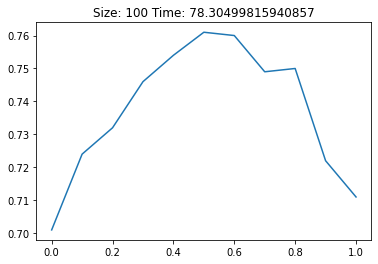


Doing size 500
Fitted vocab size: 3885
Deleting 2 constituting 3.9603960396039605e-05 percent
Fitted vocab size: 3885
Deleting 5000 constituting 0.09900990099009901 percent
Fitted vocab size: 4000
Deleting 10000 constituting 0.19801980198019803 percent
Fitted vocab size: 3922
Deleting 15000 constituting 0.297029702970297 percent
Fitted vocab size: 4000
Deleting 20000 constituting 0.39603960396039606 percent
Fitted vocab size: 3967
Deleting 25000 constituting 0.49504950495049505 percent
Fitted vocab size: 4000
Deleting 30000 constituting 0.594059405940594 percent
Fitted vocab size: 3984
Deleting 35000 constituting 0.693069306930693 percent
Fitted vocab size: 4000
Deleting 40000 constituting 0.7920792079207921 percent
Fitted vocab size: 3804
Deleting 45000 constituting 0.8910891089108911 percent
Fitted vocab size: 4000
Deleting 50000 constituting 0.9900990099009901 percent
Fitted vocab size: 3709


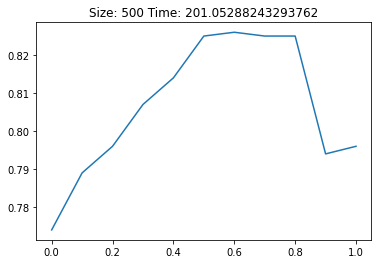


Doing size 2000
Fitted vocab size: 4000
Deleting 2 constituting 4.6550600502746487e-05 percent
Fitted vocab size: 4000
Deleting 4096 constituting 0.0953356298296248 percent
Fitted vocab size: 4000
Deleting 8192 constituting 0.1906712596592496 percent
Fitted vocab size: 4000
Deleting 12288 constituting 0.2860068894888744 percent
Fitted vocab size: 4000
Deleting 16384 constituting 0.3813425193184992 percent
Fitted vocab size: 4000
Deleting 20482 constituting 0.47672469974862675 percent
Fitted vocab size: 4000
Deleting 24578 constituting 0.5720603295782516 percent
Fitted vocab size: 4000
Deleting 28674 constituting 0.6673959594078763 percent
Fitted vocab size: 4000
Deleting 32770 constituting 0.7627315892375012 percent
Fitted vocab size: 4000
Deleting 36866 constituting 0.858067219067126 percent
Fitted vocab size: 4000
Deleting 40964 constituting 0.9534493994972535 percent
Fitted vocab size: 4000


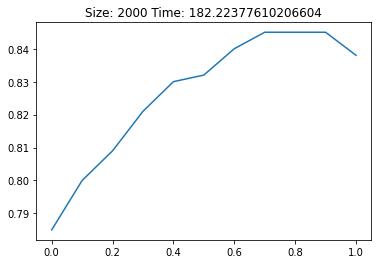

In [3]:
## PYTORCH - QUALITY CHECK - EXCLUDING 2000
from time import time

method = "clean_gpt_"
ns = [10, 50, 100, 500, 2000]
results = [['n', 'aug_n', 'acc']]
for n in ns:
    print('\nDoing size', n)
    X_all, Y_all = get_data(method + str(n))

    transformer = OnehotTransformer(ngram_range=(1, 1), min_df=0.0001, max_df=0.5, verbose_vocab=True, max_features=4000)
    transformer.fit(X_all, Y_all)
    X = transformer.transform(X_all)
    model = LogisticRegressionPytorch(input_dim=len(X[0]),epochs=200,progress_bar=False)
    batch_size = min(int(len(X_all)*0.1)-1, 4096)
    if batch_size < 10:
        batch_size = 10
    model.train(X, Y_all, batch_size=batch_size)
    probs = model.predict_proba(X)
    poor_idxs = sorted([((p - l), i) for p, l, i in zip(probs[:,1], Y_all, range(len(probs)-n))], reverse=True)

    start = time()
    ps, scores = [], []
    for del_p in range(0, 101, 10):
        half_del_size = max(1, int((del_p / 100)*len(poor_idxs))//2)
        del_idxs = set(i for (p, i) in poor_idxs[:half_del_size] + poor_idxs[-half_del_size:])
        print('Deleting', len(del_idxs), 'constituting', len(del_idxs)/len(X_all), 'percent')
        X = [x for i, x in enumerate(X_all) if i not in del_idxs]
        Y = [y for i, y in enumerate(Y_all) if i not in del_idxs]
        transformer = OnehotTransformer(ngram_range=(1, 1), min_df=0.0001, max_df=0.5, verbose_vocab=True, max_features=4000)
        transformer.fit(X,Y)
        X = transformer.transform(X)
        model = LogisticRegressionPytorch(input_dim=len(X[0]),epochs=200,progress_bar=False)
        batch_size = min(int(len(X)*0.1)-1, 4096)
        if batch_size < 10:
            batch_size = 10
        model.train(X, Y, batch_size=batch_size)
        del X, Y
        with torch.no_grad():
            acc = model.score(transformer.transform(Xt), Yt.copy())
            scores.append(acc)
            ps.append(del_p/100)
        del model, transformer, acc
        results.append([n, len(X), acc])
    
    plt.plot(ps, scores)
    plt.title('Size: ' + str(n) + ' Time: ' + str(time() - start))
    plt.show()

Augmented 'x' size of original: 1099.4 for size 10
Fitted vocab size: 180
Fitted vocab size: 960
Fitted vocab size: 1261
Fitted vocab size: 1484
Fitted vocab size: 1645
Fitted vocab size: 1801
Fitted vocab size: 1922
Fitted vocab size: 2045
Fitted vocab size: 2164
Fitted vocab size: 2272
Fitted vocab size: 1441


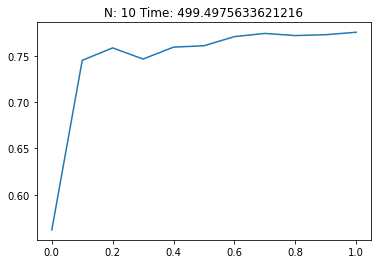

Augmented 'x' size of original: 999.0 for size 50
Fitted vocab size: 940
Fitted vocab size: 3471
Fitted vocab size: 2650
Fitted vocab size: 3088
Fitted vocab size: 2772
Fitted vocab size: 3020
Fitted vocab size: 2833
Fitted vocab size: 3036
Fitted vocab size: 2869
Fitted vocab size: 3003
Fitted vocab size: 3157


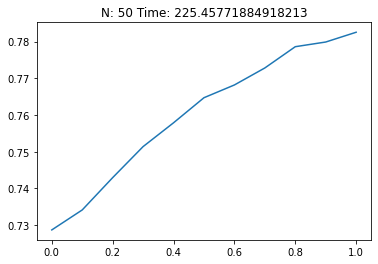

Augmented 'x' size of original: 182.52 for size 100
Fitted vocab size: 1288
Fitted vocab size: 2575
Fitted vocab size: 3215
Fitted vocab size: 3671
Fitted vocab size: 4039
Fitted vocab size: 4361
Fitted vocab size: 2912
Fitted vocab size: 3086
Fitted vocab size: 3224
Fitted vocab size: 3377
Fitted vocab size: 3518


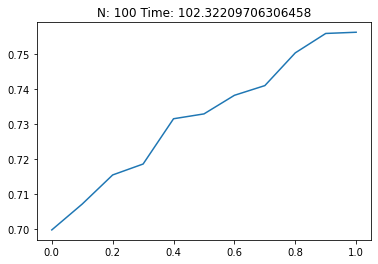

Augmented 'x' size of original: 99.0 for size 500
Fitted vocab size: 3709
Fitted vocab size: 5100
Fitted vocab size: 3847
Fitted vocab size: 4252
Fitted vocab size: 3910
Fitted vocab size: 4147
Fitted vocab size: 3897
Fitted vocab size: 4062
Fitted vocab size: 3882
Fitted vocab size: 4006
Fitted vocab size: 4134


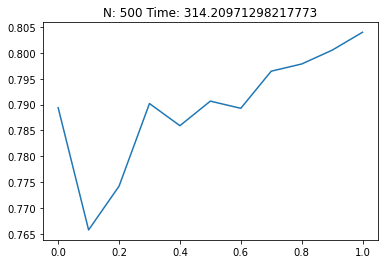

Augmented 'x' size of original: 5.229 for size 2000
Fitted vocab size: 8963
Fitted vocab size: 9106
Fitted vocab size: 9245
Fitted vocab size: 9356
Fitted vocab size: 9462
Fitted vocab size: 9579
Fitted vocab size: 9707
Fitted vocab size: 9801
Fitted vocab size: 6461
Fitted vocab size: 6655
Fitted vocab size: 6785


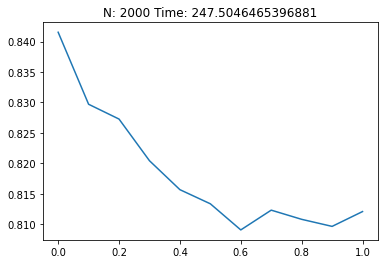

In [18]:
PYTORCH = True

clean = 'clean_' # Type either '' or 'clean_'
method = "gpt"
ns = [10, 50, 100, 500, 2000]


for n in ns:
    data_type = clean + method + f"_{n}"
    X_all, Y_all = get_data(data_type)
    X_all, Y_all = X_all[-50_000:], Y_all[-50_000:]
    aug_len = len(X_all) - n
    print("Augmented 'x' size of original:", aug_len/n, "for size", n)
    start = time()
    ps, scores = [], []
    for i in range(0, 101, 10):
        p = i/100
        data_size = int(n + p*aug_len) # exclusive to avoid indexing [-1:]
        X, Y = X_all[-data_size:], Y_all[-data_size:]
        
        if PYTORCH:
            transformer = OnehotTransformer(ngram_range=(1, 1), min_df=0.001, max_df=0.5, verbose_vocab=True)
            transformer.fit(X,Y)
            X = transformer.transform(X)

            model = LogisticRegressionPytorch(input_dim=len(X[0]),epochs=200,progress_bar=False)
            batch_size = min(int(data_size*0.1)-1, 4096)
            if batch_size < 10:
                batch_size = 10
            model.train(X, Y, batch_size=batch_size)

            acc = model.score(transformer.transform(Xt),Yt)
        else: #SKLEARN
            model = LogisticRegression(max_iter=100, ngram_range=(1, 1), min_df=0.0001, max_df=.5, verbose_vocab=True)
            model.fit(X, Y)
            acc = (model.predict(Xt) == np.array(Yt)).mean()
            
        scores.append(acc)
        ps.append(p)
    plt.plot(ps, scores)
    plt.title('N: ' + str(n) + ' Time: ' + str(time() - start))
    plt.show()

In [3]:
for dataset in ('clean_other_yelp', 'clean_other_movie'):
    X, Y = get_data(dataset)

    transformer = OnehotTransformer(ngram_range=(1, 1), min_df=0.0001, max_df=0.8, verbose_vocab=True, max_features=10_000)
    transformer.fit(X,Y)
    X = transformer.transform(X)

    model = LogisticRegressionPytorch(input_dim=len(X[0]),epochs=200,progress_bar=False)
    batch_size = min(int(len(X)*0.1)-1, 4096)
    if batch_size < 10:
        batch_size = 10
    model.train(X, Y, batch_size=batch_size)

    acc = model.score(transformer.transform(Xt),Yt)
    print(acc)

Fitted vocab size: 10000
0.822
Fitted vocab size: 9847
0.766
